In [1]:
from Source.StockExchange import StockExchange
from Source.DealerEnvironment import DealerEnvironment

from Source.Agents.BaselineAgents import RandomAgent, RecycleAgent
from Source.Agents.DeepQNetwork import DQNMarketMaker

import numpy as np
import matplotlib.pyplot as plt

In [2]:
TOTAL_STEPS = 5000
TOTAL_EPISODES = 3

DQN_ACTION_SPACE = [-1.0, -0.5, 0.0, 0.5, 1.0]
STATE_SPACE_SIZE = 3

In [3]:
stockExchange = StockExchange(TOTAL_STEPS)

dealerEnv1 = DealerEnvironment(dealerId="dealer1", exchange=stockExchange)
dealerEnv2 = DealerEnvironment(dealerId="dealer2", exchange=stockExchange)
dealerEnv3 = DealerEnvironment(dealerId="dealer3", exchange=stockExchange)

marketMaker1 = RandomAgent(low=-1.0, high=1.0)
marketMaker2 = DQNMarketMaker(DQN_ACTION_SPACE, STATE_SPACE_SIZE)
marketMaker3 = RecycleAgent(offset=0.3)

In [4]:
dqnInventory = []
dqnTotalReturn = [0.0]
randomAgentTotalReturn = [0.0]
recycleAgentTotalReturn = [0.0]

for episodeNumber in range(TOTAL_EPISODES):
    stockExchange.reset()
    state1 = dealerEnv1.reset()
    state2 = dealerEnv2.reset()
    state3 = dealerEnv3.reset()

    dealer1Return = 0.0
    dealer2Return = 0.0
    dealer3Return = 0.0

    while stockExchange.isEpisodeLive():
        skewAction1, _ = marketMaker1.getSkewAction(state1)
        skewAction2, skewActionIndex2 = marketMaker2.getSkewAction(state2)
        skewAction3, _ = marketMaker1.getSkewAction(state3)

        dealerEnv1.submitSkewToExchange(skewAction1)
        dealerEnv2.submitSkewToExchange(skewAction2)
        dealerEnv3.submitSkewToExchange(skewAction3)

        stockExchange.step()

        nextState1, reward1, done1, _ = dealerEnv1.step()
        nextState2, reward2, done2, _ = dealerEnv2.step()
        nextState3, reward3, done3, _ = dealerEnv3.step()

        marketMaker1.inputPostTrade()
        marketMaker2.inputPostTrade(state2, skewActionIndex2, reward2, done2, nextState2)
        marketMaker3.inputPostTrade()

        state1 = nextState1
        state2 = nextState2
        state3 = nextState3
        
        dealer1Return += reward1
        dealer2Return += reward2
        dealer3Return += reward3

        dqnInventory.append(state2[0])

        randomAgentTotalReturn.append(randomAgentTotalReturn[-1] + reward1)
        dqnTotalReturn.append(dqnTotalReturn[-1] + reward2)
        recycleAgentTotalReturn.append(recycleAgentTotalReturn[-1] + reward3)


    print("----------------------------------")
    print("Episode:", episodeNumber)
    print("dealer1:", state1, dealer1Return)
    print("dealer2:", state2, dealer2Return)
    print("dealer3:", state3, dealer3Return)



----------------------------------
Episode: 0
dealer1: (-3.0, 89.00797051795058, 0) 52.05989682677504
dealer2: (15.0, 89.00797051795058, 1) 24.526874034113384
dealer3: (-5.0, 89.00797051795058, 0) 134.92344019945998
----------------------------------
Episode: 1
dealer1: (-11.0, 69.58312274806954, 0) 676.8184536015531
dealer2: (-19.0, 69.58312274806954, 0) 480.37058919827706
dealer3: (15.0, 69.58312274806954, 0) -422.74863989077045
----------------------------------
Episode: 2
dealer1: (9.0, 65.40813828979873, 0) 20.467450446455825
dealer2: (6.0, 65.40813828979873, 0) -319.0562178021987
dealer3: (11.0, 65.40813828979873, 0) -162.19180613648567


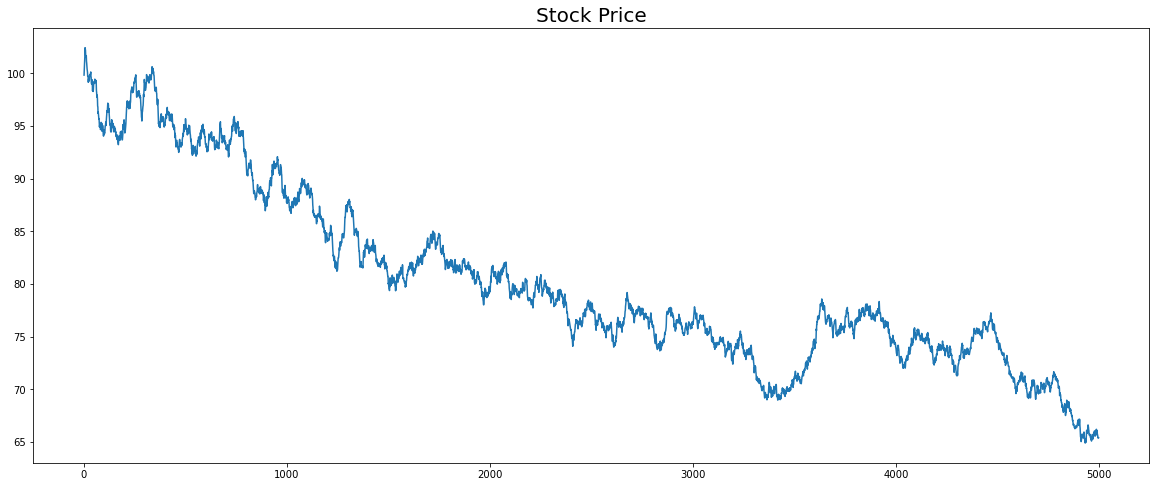

In [5]:
plt.figure(figsize=(20,8))
plt.plot(stockExchange._stockPriceProcess._priceProcess)
plt.title("Stock Price", size=20)
plt.show()

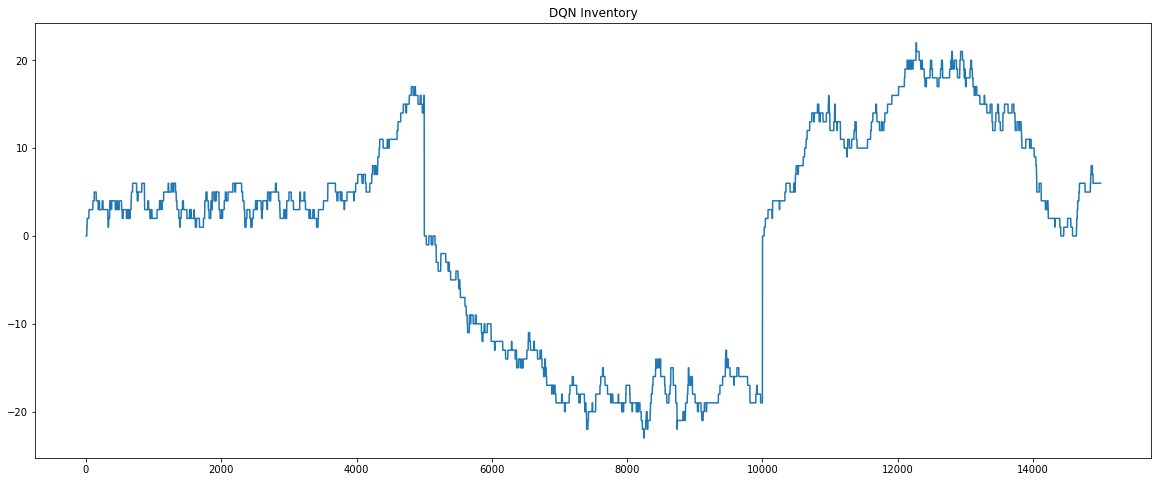

In [6]:
plt.figure(figsize=(20,8))
plt.plot(dqnInventory)
plt.title("DQN Inventory")
plt.show()

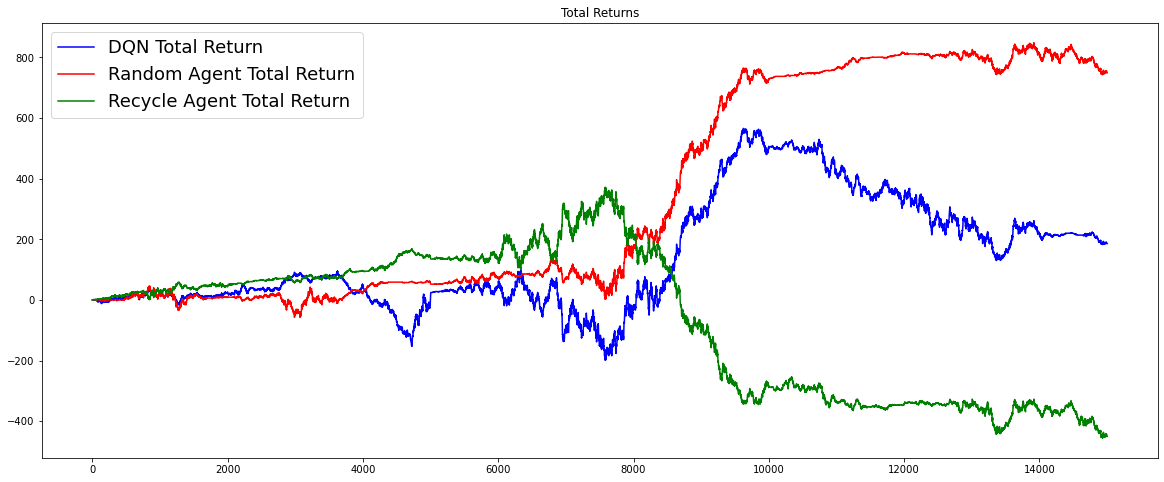

In [7]:
plt.figure(figsize=(20,8))
plt.plot(dqnTotalReturn, label='DQN Total Return', color='blue')
plt.plot(randomAgentTotalReturn, label='Random Agent Total Return', color='red')
plt.plot(recycleAgentTotalReturn, label='Recycle Agent Total Return', color='green')
plt.title("Total Returns")
plt.legend(fontsize=18)
plt.show()